#### CONVERTING RAW CSV DATASET TO UNSTRUCTURED JSON DATA

In [257]:
import pandas as pd
import pymongo
import psycopg2
import json
import pandas as pd
import re


# Load the CSV file into a DataFrame
df = pd.read_csv(r'C:/Users/jebitta joseph/Desktop/DAP/PROJECT/DataSet/cancerregion-new.csv')

# Convert DataFrame to JSON
json_data = df.to_json(orient='records')

# Save JSON data to a file
with open(r'C:/Users/jebitta joseph/Desktop/DAP/PROJECT/DataSet/region-details.json', 'w') as json_file:
    json_file.write(json_data)
    
print("convereted csv raw to unstructured json")


convereted csv raw to unstructured json


#### SETTING PARAMETERS AND CONNECTING TO MONGODB AND POSTGRE

In [258]:
# Define file path and connection parameters
JSON_FILE_PATH = 'C:/Users/jebitta joseph/Desktop/DAP/PROJECT/DataSet/region-details.json'
MONGODB_DB = "Datas"
MONGODB_COLLECTION = "location-region"
POSTGRE_HOST = "localhost"
POSTGRE_DB = "dap_data"
POSTGRE_USER = "postgres"
POSTGRE_PASSWORD = "root"
POSTGRE_TABLE = "regiondata"
POSTGRE_PORT = "5432"

# Connect to MongoDB
client = pymongo.MongoClient()
db = client[MONGODB_DB]
collection = db[MONGODB_COLLECTION]

# Connect to PostgreSQL
conn = psycopg2.connect(
    host=POSTGRE_HOST,
    database=POSTGRE_DB,
    user=POSTGRE_USER,
    password=POSTGRE_PASSWORD,
    port=POSTGRE_PORT
)
cur = conn.cursor()

print("connected")

connected


#### SAVE RAW UNSTRUCTRED DATASET TO MONGODB FOR E-T

In [259]:
#Save JSON data to MongoDB, overwrite collection if it exists
with open(JSON_FILE_PATH) as f:
    data = json.load(f)
    collection.delete_many({})  # Delete all documents in the collection
    collection.insert_many(data)  # Insert the new data
print("Number Of RaW Data :", collection.count_documents({}))

print("loaded raw data to mongodb")

Number Of RaW Data : 24164
loaded raw data to mongodb


#### EXTRACTION OF DATA FROM MONGODB

In [260]:
# Extract data from MongoDB
mongodb_data = list(collection.find())
df = pd.DataFrame(mongodb_data)
print("Number extracted data/raw data :", len(df))

Number extracted data/raw data : 24164


#### Defining and loading region boundaries of New York City for ease of processing

In [261]:
import psycopg2

# Define region boundaries
region_boundaries = {
    'Brooklyn Southwest': (40.5700, 40.6500, -74.03, -73.97),
    'Queens Northeast': (40.7600, 40.8000, -73.78, -73.72),
    'Brooklyn East': (40.6300, 40.7200, -73.97, -73.88),
    'Bronx North': (40.8800, 40.9200, -74.0, -73.9),
    'Manhattan Central': (40.7000, 40.8100, -74.02, -73.93),
    'Manhattan South': (40.6800, 40.7900, -74.02, -73.97),
    'Bronx South Central': (40.8000, 40.8800, -74.0, -73.87),
    'Queens West': (40.6800, 40.7700, -73.92, -73.79),
    'Queens South': (40.5700, 40.6900, -73.92, -73.73),
    'New York City Centre': (40.7500, 40.7810, -73.7, -73.65),
    'Staten Island': (40.4800, 40.6500, -74.28, -74.01)
}
# Create a cursor object using the cursor() method
cursor = conn.cursor()

#  Drop existing PostgreSQL table if it exists
cursor.execute("DROP TABLE IF EXISTS region_boundaries;")



# Create table
create_table_query = '''
CREATE TABLE region_boundaries (
    region TEXT PRIMARY KEY,
    min_latitude FLOAT,
    max_latitude FLOAT,
    min_longitude FLOAT,
    max_longitude FLOAT
);
'''
cursor.execute(create_table_query)
conn.commit()

# Insert data into table
for region, (min_lat, max_lat, min_long, max_long) in region_boundaries.items():
    insert_query = "INSERT INTO region_boundaries (region, min_latitude, max_latitude, min_longitude, max_longitude) VALUES (%s, %s, %s, %s, %s)"
    cursor.execute(insert_query, (region, min_lat, max_lat, min_long, max_long))
    conn.commit()




#### Cleaning and Transformation of Data

In [262]:
# Define function to assign regions based on latitude and longitude - Transform data
def assign_region(latitude, longitude):
    cur.execute("SELECT region FROM region_boundaries WHERE %s BETWEEN min_latitude AND max_latitude AND %s BETWEEN min_longitude AND max_longitude", (latitude, longitude))
    result = cur.fetchone()
    if result:
        return result[0]
    else:
        return 'Other Cities'

# Drop rows where latitude or longitude is null or contains special characters or alphabets
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])
print("Number of data after deletion of null values in Longitude/Latitude Columns(cleaning of data):", len(df))

df = df[df['LATITUDE'].astype(str).str.match(r'^-?\d+(?:\.\d+)?$') & df['LONGITUDE'].astype(str).str.match(r'^-?\d+(?:\.\d+)?$')]
print("Number of data after deletion of special character/alphabets in Longitude/Latitude Columns(cleaning of data):", len(df))

# Rename columns to match the expected keys
df.rename(columns={'LATITUDE': 'latitude', 'LONGITUDE': 'longitude'}, inplace=True)

# Perform transformation - region assigned to each data entry based on function definition
df['region'] = df.apply(lambda row: assign_region(row['latitude'], row['longitude']), axis=1)

print("region mapped")

Number of data after deletion of null values in Longitude/Latitude Columns(cleaning of data): 23453
Number of data after deletion of special character/alphabets in Longitude/Latitude Columns(cleaning of data): 23268
region mapped


#### Loading of relevent data required for processing and visualisation to PosteGre

In [263]:

# Drop existing PostgreSQL table if it exists
cur.execute("DROP TABLE IF EXISTS {};".format(POSTGRE_TABLE))

# Save transformed data to PostgreSQL
cur.execute("CREATE TABLE IF NOT EXISTS {} (id SERIAL PRIMARY KEY, latitude FLOAT, longitude FLOAT, region VARCHAR);".format(POSTGRE_TABLE))
for index, row in df.iterrows():
    cur.execute("INSERT INTO {} (latitude, longitude, region) VALUES (%s, %s, %s);".format(POSTGRE_TABLE), (row['latitude'], row['longitude'], row['region']))
#print("Number of rows after Step 5:", len(df))
cur.execute("SELECT COUNT(*) FROM {};".format(POSTGRE_TABLE))
final_data_count = cur.fetchone()[0]
print("Number of data loaded to PostgreSQL:", final_data_count)
print("Data successfully loaded into PostgreSQL.")



Number of data loaded to PostgreSQL: 23268
Data successfully loaded into PostgreSQL.


#### Acquire data from PostGre for visulaisation

In [264]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt


# Query latitude, longitude, and region from the PostgreSQL table
query = "SELECT latitude, longitude, region FROM {};".format(POSTGRE_TABLE)
df = pd.read_sql_query(query, conn)

# Commit changes and close connections
conn.commit()
conn.close()
client.close()

print("data extracted from postgre")


data extracted from postgre


C:\Users\Lekshmi Sasidharan\AppData\Local\Temp\ipykernel_26228\2369324708.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


#### Region data plotted as scattered graph for visulaisation

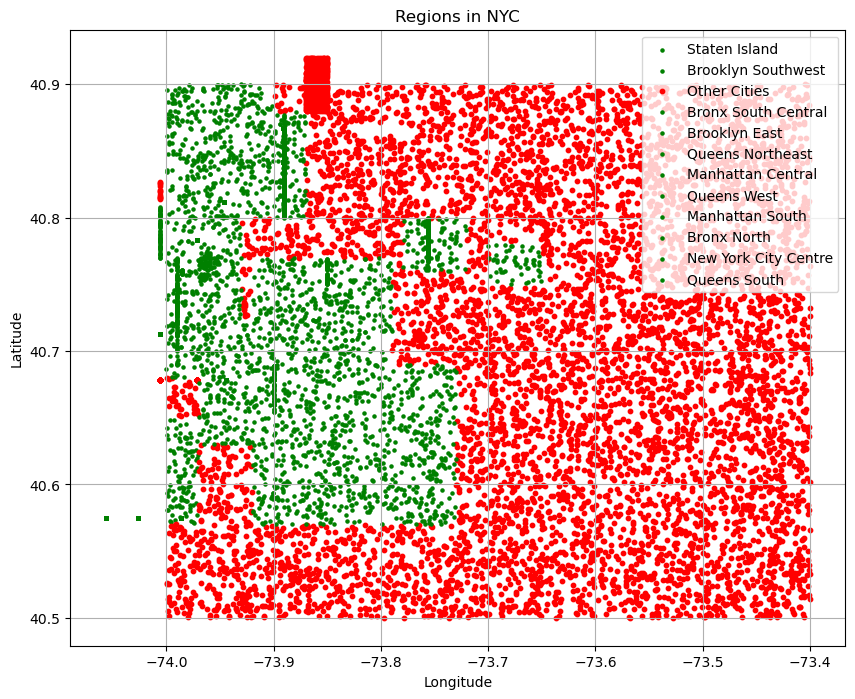

Regions covered


In [265]:
# Plot the graph
plt.figure(figsize=(10, 8))

# Plot regions from the table
for region in df['region'].unique():
    region_data = df[df['region'] == region]
    size_factor = 10 if region == 'Other Cities' else 5  # Adjust size based on region
    color = 'red' if region == 'Other Cities' else 'green'  # Red for Other Cities, Green for the rest
    plt.scatter(region_data['longitude'], region_data['latitude'], label=region, color=color, s=size_factor)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regions in NYC')
plt.legend()
plt.grid(True)
plt.show()

print("Regions covered")


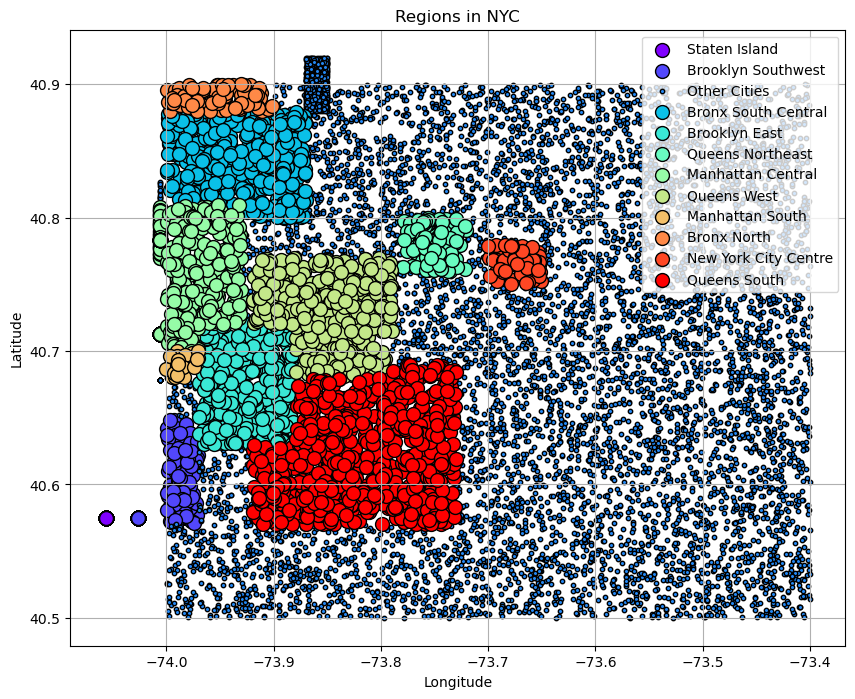

Regions covered


In [266]:
import matplotlib.pyplot as plt
import numpy as np

# Get a list of unique regions and assign a unique color to each region
unique_regions = df['region'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_regions)))  # Generate colors from the rainbow colormap

# Plot the graph
plt.figure(figsize=(10, 8))

# Plot regions from the table
for i, region in enumerate(unique_regions):
    region_data = df[df['region'] == region]
    size_factor = 10 if region == 'Other Cities' else 100  # Adjust size based on region
    plt.scatter(region_data['longitude'], region_data['latitude'], label=region, color=colors[i], s=size_factor, edgecolor='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regions in NYC')
plt.legend()
plt.grid(True)
plt.show()

print("Regions covered")
